<a href="https://colab.research.google.com/github/YusufDilekci/Sarcasm_Recognition/blob/main/sarcasm_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Installation of the all required packages and libraries**



In [8]:
!pip install spacy
!python -m spacy download en_core_web_lg
!pip install gensim
!pip install transformers
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's 

**Loading pre-train google-news word2vec vector representation for text**

In [3]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


**Loading en_core_web_lg nlp model**

In [4]:
import spacy

nlp = spacy.load("en_core_web_lg")

**Establish a connection between google drive and colab**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Get the dataset file which we are gonna use it from google drive**

In [6]:
import shutil
import os
shutil.copy('/content/drive/MyDrive/Sarcasm_Detection/sarcasm.csv', os.getcwd())

'/content/sarcasm.csv'

**Read csv with pandas as dataframe**

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("sarcasm.csv")
df.head()

,class,text
0,notsarc,"If that's true, then Freedom of Speech is doom..."
1,notsarc,Neener neener - is it time to go in from the p...
2,notsarc,"Just like the plastic gun fear, the armour pie..."
3,notsarc,So geology is a religion because we weren't he...
4,notsarc,Well done Monty. Mark that up as your first ev...


**Analyze and extract meaningful information related with data**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9386 entries, 0 to 9385
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   9386 non-null   object
 1   text    9386 non-null   object
dtypes: object(2)
memory usage: 146.8+ KB


In [ ]:
df['class'].value_counts()

,count
class,
notsarc,4693
sarc,4693


**Convert some columns to numerical datatype**

In [12]:
df['class_num'] = df['class'].apply(lambda x : 1 if x == 'sarc' else 0)

In [ ]:
df['glove_vector'] = df['text'].apply(lambda x: nlp(x).vector)

**Perform nlp data preprocessing operations like remove punct and stopwords, lemmatization to use convenient format in model**

In [ ]:
def preprocess_and_vectorize(text):
    all_clean_tokens = [token.lemma_.lower() for token in nlp(text) if not token.is_stop and not token.is_punct]
    return wv.get_mean_vector(all_clean_tokens)

df['gensim_vector'] = df['text'].apply(preprocess_and_vectorize)

In [ ]:
df.head()

,class,text,class_num,glove_vector,gensim_vector
0,notsarc,"If that's true, then Freedom of Speech is doom...",0,"[-0.76626986, 1.4253579, -2.5212822, -1.286170...","[0.028688896, 0.0056534708, 0.007524069, 0.029..."
1,notsarc,Neener neener - is it time to go in from the p...,0,"[-0.41781142, 4.458112, -2.5987816, 0.42482427...","[-0.0014881147, 0.058390122, 0.036367316, 0.06..."
2,notsarc,"Just like the plastic gun fear, the armour pie...",0,"[-1.964692, -0.72769564, -0.93318206, 1.239436...","[0.02869091, 0.042279355, 0.007586536, 0.02459..."
3,notsarc,So geology is a religion because we weren't he...,0,"[-1.9414376, 4.8499994, -2.7247503, -0.0957217...","[0.02096812, -0.0104743205, 0.021920618, 0.038..."
4,notsarc,Well done Monty. Mark that up as your first ev...,0,"[-1.3936415, -2.0412686, -2.7562578, 0.8716953...","[0.0232634, -0.022459248, 0.012941596, 0.03351..."


**Split the data to train and test**

In [ ]:
from sklearn.model_selection import train_test_split

X = df['gensim_vector']
y = df['class_num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Unsquuze or reshape the array**

In [ ]:
X_train_2d = np.stack(X_train)
X_test_2d =  np.stack(X_test)

**Apply different traditional machine learning algorithms to see performations of models by looking some metrics to decide best model**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, f1_score


ml_models = [
    ("DT", DecisionTreeClassifier()),
    ("MNB", MultinomialNB()),
    ("SVM", svm.SVC(kernel='rbf')),
    ("KNN", KNeighborsClassifier(n_neighbors=8)),
    ("RF", RandomForestClassifier(max_depth=2, random_state=0)),
    ("GB", GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=6, random_state=0)),
    ("XGB", XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.01, objective='binary:logistic'))
]

def base_models(models):
  scaler = MinMaxScaler()
  X_train_scaled = scaler.fit_transform(X_train_2d)
  X_test_scaled = scaler.transform(X_test_2d)

  for name, model in models:
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    f1 = f1_score(y_test, y_pred, average=None)
    print("---------F1 SCORES-----------")
    print(name, "|", f1)

base_models(ml_models)

---------F1 SCORES-----------
DT | [0.60677784 0.61465472]
---------F1 SCORES-----------
MNB | [0.70304302 0.69405405]
---------F1 SCORES-----------
SVM | [0.72008663 0.72917758]
---------F1 SCORES-----------
KNN | [0.70348028 0.60087445]
---------F1 SCORES-----------
RF | [0.69802245 0.70026525]
---------F1 SCORES-----------
GB | [0.70188679 0.70910047]
---------F1 SCORES-----------
XGB | [0.70111881 0.70143693]



# Neural Network Model



In [9]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
from datasets import Dataset

data = {
    "text": df["text"].tolist(),
    "label": df['class_num'].tolist()
}
dff = pd.DataFrame(data)
dataset = Dataset.from_pandas(dff)
print(dataset)

Dataset({
    features: ['text', 'label'],
    num_rows: 9386
})


**Implement all text to vector representation using AutoTokenizer from pre-train model**

In [21]:
from transformers import AutoTokenizer


tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)


tokenized_datasets = dataset.map(tokenize_function)
tokenized_datasets.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

print(tokenized_datasets)

Map:   0%|          | 0/9386 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 9386
})


In [24]:
train_test_split = tokenized_datasets.train_test_split(test_size=0.2, seed=42)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

train_test_split

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7508
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1878
    })
})

**Set the training arguments**

In [33]:
vocab_size = tokenizer.vocab_size
embedding_dim = 300
hidden_dim = 128
num_classes = 1
num_heads = 4
batch_size = 32
num_epochs = 10
learning_rate = 1e-3

**Put training and test data into the DataLoader Structure**

In [26]:
training_data = train_test_split['train']
test_data = train_test_split['test']


train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)


**Create a Custom Transformer_Only_Encoder based model then choose appropriate Loss Function and Optimizer in terms of task**

In [34]:
class TextClassifierTransformerModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes, num_heads):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout = nn.Dropout(0.5)
        self.attention = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads, batch_first=True)
        self.fc = nn.Linear(embedding_dim, num_classes)
        self.bn = nn.BatchNorm1d(embedding_dim)

    def forward(self, input_ids, attention_mask=None):
        embeddings = self.dropout(self.embedding(input_ids))
        embeddings = self.bn(embeddings.transpose(1, 2)).transpose(1, 2)

        extended_mask = None
        if attention_mask is not None:
            extended_mask = attention_mask.unsqueeze(1).repeat(num_heads, embeddings.size(1), 1)
            extended_mask = (1.0 - extended_mask) * -1e9

        attention_output, _ = self.attention(embeddings, embeddings, embeddings, attn_mask=extended_mask)
        attention_output = self.dropout(attention_output)

        logits = self.fc(attention_output.mean(dim=1))
        return logits


model = TextClassifierTransformerModel(vocab_size, embedding_dim, num_classes, num_heads).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

**Train and Evaluate Model with Test Set**

In [35]:
def train_loop(dataloader, model, loss_fn, optimizer):
  model.train()
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  train_loss, correct = 0, 0
  for batch, data in enumerate(dataloader):
    inputs = data['input_ids'].to(device)
    y = data['label'].unsqueeze(dim=1).to(torch.float).to(device)

    y_pred = model(inputs)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    pred = torch.sigmoid(y_pred)
    correct += ((pred > 0.5) == y).type(torch.float).sum().item()

  train_loss /= num_batches
  accuracy = 100 * correct / size
  print(f"Train Error: \n Accuracy: {(accuracy):>0.1f}%, Avg loss: {train_loss:>8f} \n")

  return train_loss, accuracy



def test_loop(dataloader, model, loss_fn):
  model.eval()
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0
  with torch.inference_mode():
    for data in dataloader:
      inputs = data['input_ids'].to(device)
      y = data['label'].unsqueeze(dim=1).to(torch.float).to(device)
      pred = model(inputs)
      pred = torch.sigmoid(pred)
      test_loss += loss_fn(pred, y).item()
      correct += ((pred > 0.5) == y).type(torch.float).sum().item()
  test_loss /= num_batches
  accuracy = 100 * correct / size

  print(f"Test Error: \n Accuracy: {(accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")

  return test_loss, accuracy

train_losses = []
test_losses = []
train_scores = []
test_scores = []
for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_acc = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test_loop(test_dataloader, model, loss_fn)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_scores.append(train_acc)
    test_scores.append(test_acc)

print('Done !')

Epoch 1
-------------------------------
Train Error: 
 Accuracy: 63.3%, Avg loss: 0.646289 

Test Error: 
 Accuracy: 67.3%, Avg loss: 0.700708 

Epoch 2
-------------------------------
Train Error: 
 Accuracy: 67.2%, Avg loss: 0.603734 

Test Error: 
 Accuracy: 68.6%, Avg loss: 0.702604 

Epoch 3
-------------------------------
Train Error: 
 Accuracy: 68.6%, Avg loss: 0.583262 

Test Error: 
 Accuracy: 68.7%, Avg loss: 0.698111 

Epoch 4
-------------------------------
Train Error: 
 Accuracy: 69.9%, Avg loss: 0.576807 

Test Error: 
 Accuracy: 67.6%, Avg loss: 0.704619 

Epoch 5
-------------------------------
Train Error: 
 Accuracy: 71.0%, Avg loss: 0.566060 

Test Error: 
 Accuracy: 68.4%, Avg loss: 0.699626 

Epoch 6
-------------------------------
Train Error: 
 Accuracy: 71.3%, Avg loss: 0.554721 

Test Error: 
 Accuracy: 70.3%, Avg loss: 0.693474 

Epoch 7
-------------------------------
Train Error: 
 Accuracy: 73.2%, Avg loss: 0.542668 

Test Error: 
 Accuracy: 68.5%, Avg lo

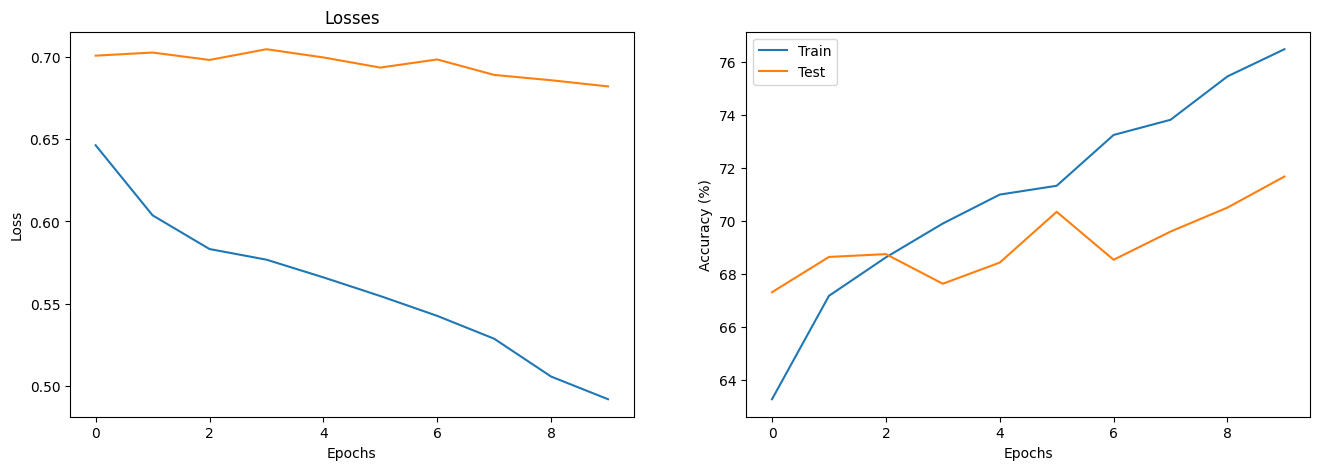

In [36]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(train_losses)
ax[0].plot(test_losses)

ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_title("Losses")


ax[1].plot(train_scores, label="Train")
ax[1].plot(test_scores, label="Test")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_xlabel("Epochs")
ax[1].set_ylim()
ax[1].set_xlim()
ax[1].legend()

plt.legend()
plt.show()

# Transfer Learning, Fine Tuning with Pre-Train Transformers Model

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    report_to=["none"],
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import AutoModelForSequenceClassification, Trainer

bert_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=2).to(device)

trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    device=device
)
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.549300,0.463043
2,0.349500,0.624342
3,0.238500,0.837063


TrainOutput(global_step=2817, training_loss=0.35952810112110556, metrics={'train_runtime': 2281.8974, 'train_samples_per_second': 9.871, 'train_steps_per_second': 1.234, 'total_flos': 5926313410928640.0, 'train_loss': 0.35952810112110556, 'epoch': 3.0})

In [ ]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.837062656879425, 'eval_runtime': 53.0785, 'eval_samples_per_second': 35.382, 'eval_steps_per_second': 4.427, 'epoch': 3.0}


# Load a Custom Model From Hugging Face Hub

In [ ]:
from transformers import pipeline

MODEL_PATH = "helinivan/english-sarcasm-detector"
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
inference_pipeline = pipeline("text-classification", model=model, tokenizer=tokenizer, device=device)


test_texts = train_test_split["test"]["text"]
predictions = inference_pipeline(test_texts)


In [ ]:

df_result = pd.DataFrame(zip(test_texts, predictions), columns=['TEXT', 'PREDICTION'])
df_result.head()

,TEXT,PREDICTION
0,Except that the word for day in Genesis 1 is '...,"{'label': 'LABEL_0', 'score': 0.9586531519889832}"
1,And people say I make strawman arguments.Simpl...,"{'label': 'LABEL_0', 'score': 0.9902228116989136}"
2,"Man, these guys can't even get into the scienc...","{'label': 'LABEL_0', 'score': 0.709625780582428}"
3,No it means that the genome operates in a more...,"{'label': 'LABEL_0', 'score': 0.9932511448860168}"
4,Wouldn't it be wonderful if every woman in the...,"{'label': 'LABEL_0', 'score': 0.9954440593719482}"
